# Analysis for COVID-19


### Name: Jinghan Xu, Zuer Zheng, Fengsheng Zhou, Xueyin Zhu
****
#### Motivation:

COVID-19 is an infectious disease. The first known case was detected in December 2019. Since then, the disease has spread around the world, leading to an ongoing pandemic. So far, COVID-19 is still with us and new strains continue to be discovered. 

In this project, we would like to collate data about COVID-19 cases to help analysts better analyze the disease and give viewers a clear picture of the overall trend of cases globally.Therefore, we look into the COVID-19 data, expecting to find the relationship between the variables as well as any interesting patterns. 
****
#### Our project comprises the following sections:<br>

[1. Get Data](#1.-Get-Data)<br>
[2. Data Exploration](#2.-Data-Exploration)<br>
&emsp;&emsp;[2.1. Key Countries' Death Amount Analysis](#2.1.-Key-Countries'-Death-Amount-Analysis)<br>
&emsp;&emsp;[2.2. Global Confirmed & Death Cases](#2.2.-Global-Confirmed-&-Death-Cases)<br>
&emsp;&emsp;[2.3. Worldwide Increasing Rate Analysis](#2.3.-Worldwide-Increasing-Rate-Analysis)<br>
&emsp;&emsp;[2.4. Confirmed Cases Among States Of The US](#2.4.-Confirmed-Cases-Among-States-Of-The-US)<br>
&emsp;&emsp;[2.5. Confirmed & Vaccinated Cases Among Counties Of California](#2.5.-Confirmed-&-Vaccinated-Cases-Among-Counties-Of-California)<br>
[3. Exploratory Analysis](#3.-Exploratory-Analysis)<br>
&emsp;&emsp;[3.1. Boost Shot's Impact On COVID-19 Death Rate In California](#3.1.-Boost-Shot's-Impact-On-COVID-19-Death-Rate-In-California)<br>
&emsp;&emsp;[3.2. Vaccine Amount's Impact On COVID-19 Death Rate In California](#3.2.-Vaccine-Amount's-Impact-On-COVID-19-Death-Rate-In-California)<br>
&emsp;&emsp;[3.3. Best Vaccine In California](#3.3.-Best-Vaccine-In-California)<br>
[4. Conclusion](#4.-Conclusion)

## 1. Get Data
****
In this section, we crawl the COVID-19 data from the datahub and store each table in a list of data frames.

In [ ]:
# import urllib.request, urllib.parse, urllib.error
# import lxml
# from collections import Counter
# import xml.etree.ElementTree as ET
# import ssl
import requests
from bs4 import BeautifulSoup
import pandas as pd
import json,sys
import re
from matplotlib import pyplot as plt
import plotnine as p9
from plotnine import *
import sqlalchemy as sqla
import numpy as np
import warnings
import statsmodels.api as sm
warnings.filterwarnings('ignore')

In [2]:
# web API,  parse HTML
url = 'https://datahub.io/core/covid-19#data-cli'
html_text = requests.get(url).text
soup = BeautifulSoup(html_text, 'html.parser')

In [3]:
html = []
df = {}
count = 1
for link in soup.find_all('a'):
    str_link = str(link.get('href'))
    if str_link.startswith('/core/covid-19/r/') and re.search('json$',str_link):
        html.append('https://datahub.io' + str_link)
        js = requests.get('https://datahub.io' + str_link).json() 
        df[count] =  pd.DataFrame(js)
        count += 1
        print(f"Loaded dataframe(shape:{df[count-1].shape}) from: {html[-1]}")

Loaded dataframe(shape:(133672, 5)) from: https://datahub.io/core/covid-19/r/countries-aggregated.json
Loaded dataframe(shape:(682, 9)) from: https://datahub.io/core/covid-19/r/key-countries-pivoted.json
Loaded dataframe(shape:(4214, 12)) from: https://datahub.io/core/covid-19/r/reference.json
Loaded dataframe(shape:(190960, 6)) from: https://datahub.io/core/covid-19/r/time-series-19-covid-combined.json
Loaded dataframe(shape:(2279244, 5)) from: https://datahub.io/core/covid-19/r/us_confirmed.json
Loaded dataframe(shape:(2279244, 5)) from: https://datahub.io/core/covid-19/r/us_deaths.json
Loaded dataframe(shape:(682, 5)) from: https://datahub.io/core/covid-19/r/worldwide-aggregate.json
Loaded dataframe(shape:(2279244, 6)) from: https://datahub.io/core/covid-19/r/us_simplified.json


In [4]:
display(df[1]) # example: the 1st table
df[1].info()

,Confirmed,Country,Date,Deaths,Recovered
0,0,Afghanistan,2020-01-22,0,0
1,0,Afghanistan,2020-01-23,0,0
2,0,Afghanistan,2020-01-24,0,0
3,0,Afghanistan,2020-01-25,0,0
4,0,Afghanistan,2020-01-26,0,0
...,...,...,...,...,...
133471,133951,Zimbabwe,2021-11-28,4705,0
133472,134226,Zimbabwe,2021-11-29,4706,0
133473,134625,Zimbabwe,2021-11-30,4707,0
133474,135337,Zimbabwe,2021-12-01,4707,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133476 entries, 0 to 133475
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Confirmed  133476 non-null  int64 
 1   Country    133476 non-null  object
 2   Date       133476 non-null  object
 3   Deaths     133476 non-null  int64 
 4   Recovered  133476 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 5.1+ MB


In [5]:
print(f"Total number of tables crawled: {len(df)}")
print(f"Total rows of data crawled: {sum([df[d].shape[0] for d in df])}")

Total number of tables crawled: 8
Total rows of data crawled: 7157438


**Conclusion:**

Since the dataset for Covid-19 updates daily, it's important to keep up to date. So we crawl the data from `datahub.com` by using Web API, parsing HTML and json. We store the tables we crawled in a dictionary and got a total of 8 data frames with a total of 7157438 rows of records.

## 2. Data Exploration
****
In this section, we explore, analyze, and visualize the data from the previous section and report our obervations in each of the sub-sections.

### 2.1. Key Countries' Death Amount Analysis
First, let's look at the death trend through time in the eight key countries: China, France, Germany, Iran, Italy, Spain, United States, United Kingdom. The table we will use is from `df[2]`, also known as the key-countries-pivoted. 

Here are the specifications of its columns:
* Date: The date of the records
* China: The death amount caused by Covid-19 in China
* France: The death amount caused by Covid-19 in France
* Germany: The death amount caused by Covid-19 in Germany
* Iran: The death amount caused by Covid-19 in Iran
* Italy: The death amount caused by Covid-19 in Italy
* Spain: The death amount caused by Covid-19 in Spain
* US: The death amount caused by Covid-19 in the United States
* United_Kingdom: The death amount caused by Covid-19 in UK

In [6]:
df[2].info()
display(df[2])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 681 entries, 0 to 680
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   China           681 non-null    int64 
 1   Date            681 non-null    object
 2   France          681 non-null    int64 
 3   Germany         681 non-null    int64 
 4   Iran            681 non-null    int64 
 5   Italy           681 non-null    int64 
 6   Spain           681 non-null    int64 
 7   US              681 non-null    int64 
 8   United_Kingdom  681 non-null    int64 
dtypes: int64(8), object(1)
memory usage: 48.0+ KB


,China,Date,France,Germany,Iran,Italy,Spain,US,United_Kingdom
0,548,2020-01-22,0,0,0,0,0,1,0
1,643,2020-01-23,0,0,0,0,0,1,0
2,920,2020-01-24,2,0,0,0,0,2,0
3,1406,2020-01-25,3,0,0,0,0,2,0
4,2075,2020-01-26,3,0,0,0,0,5,0
...,...,...,...,...,...,...,...,...,...
676,111176,2021-11-28,7722804,5804139,6108882,5007818,5131012,48241903,10202370
677,111218,2021-11-29,7731351,5854884,6113192,5015790,5153923,48438876,10245244
678,111337,2021-11-30,7778575,5923564,6117445,5028547,5164184,48555974,10285745
679,111413,2021-12-01,7829045,5999020,6121757,5043620,5174720,48691353,10333672


**Observation:** 

In this dataset, we have the death amounts caused by Covid-19 for 8 key countries and date time, which goes from 2020-1-22 to 2021-11-27. 

Since the data type of the `Date` column is **object**, which is not ideal for plotting, we will convert the `Date` column to **datetime** type; meanwhile, we want to melt the country columns of each country into rows in order to make the data more suitable for plotting.




In [7]:
melt_key_country = pd.melt(df[2], id_vars=['Date'], 
               value_vars=['China','US','United_Kingdom','Italy','France','Germany','Spain','Iran'])
melt_key_country = melt_key_country.rename(columns={'variable':'country','value':'death'})
melt_key_country['death'] = pd.to_numeric(melt_key_country['death'],errors='coerce')
melt_key_country['Date'] = melt_key_country['Date'].astype(str)
melt_key_country['Date'] = pd.to_datetime(melt_key_country['Date'])
melt_key_country

,Date,country,death
0,2020-01-22,China,548
1,2020-01-23,China,643
2,2020-01-24,China,920
3,2020-01-25,China,1406
4,2020-01-26,China,2075
...,...,...,...
5443,2021-11-28,Iran,6108882
5444,2021-11-29,Iran,6113192
5445,2021-11-30,Iran,6117445
5446,2021-12-01,Iran,6121757


Via panda melt function, we form a new data frame that have all countries in one column with their corresponding date and death values. And we are ready to plot the time series of total death in each country.

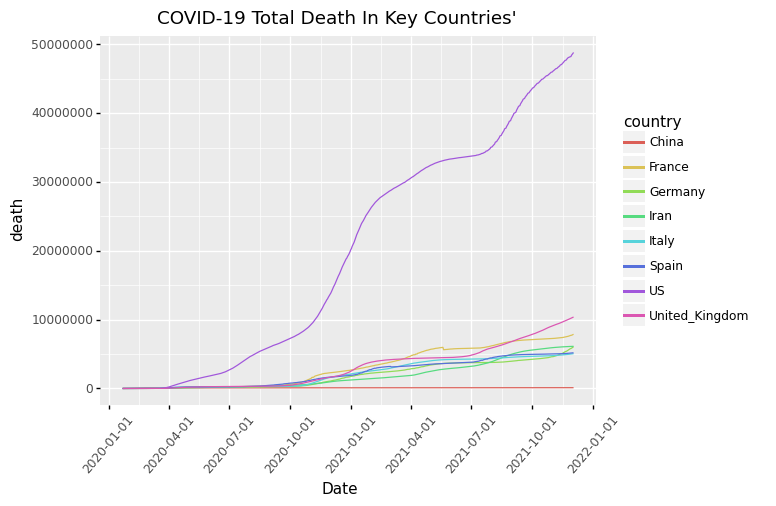

<ggplot: (142410265863)>

In [8]:
(p9.ggplot(melt_key_country)
#+ p9.facet_wrap('~country',scales = 'free') 
+ p9.aes(x='Date',y='death',colour = 'country') 
+ p9.geom_line() 
+ p9.labs(title = 'COVID-19 Total Death In Key Countries\' ')
+ p9.theme(axis_text_x = p9.element_text(angle=50))
)

**Observation**

From the plot, we can observe that overall, the death amount of each countries has an increasing trend, especially, the US, which has the largest number of death amount. Starting in April 2020, the number of death in the United States began to increase significantly. The steepest part of the US is around November 2020 and February 2021, and this is where the number of deaths increases the most. From March to August 2021, the growth rate tends to decline. However, after August 2021, the death rate increased significantly again. This trend is due to the existence of the Delta variant. 

We think that China did a good job on controlling the spread of Covid-19, and other countries may need to learn from that. We can see that there is little difference in mortality rates in the remaining seven countries until October 2020. Since then, however, the number of deaths in seven other countries, excluding China, has increased significantly. Compared to other countries, although the population base of China is huge, China’s death amount remains around the bottom line. 





### 2.2. Global Confirmed & Death Cases
****
Besides visualizing key countries' death amount, we are interested in finding out the relationship between the death amount and confirmed amount globally. For this part, we will use `df[1]`, which is also known as countries-aggregated. 

Here are the specifications of its columns:
* Confirmed: The total COVID-19 confirmed cases.
* Country: The country of the record.
* Date: The date of the record
* Deaths: The total COVID-19 death cases. 
* Recovered: The total COVID-19 recovered cases. 

In [9]:
display(df[1].info())
df[1]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133476 entries, 0 to 133475
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Confirmed  133476 non-null  int64 
 1   Country    133476 non-null  object
 2   Date       133476 non-null  object
 3   Deaths     133476 non-null  int64 
 4   Recovered  133476 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 5.1+ MB


None

,Confirmed,Country,Date,Deaths,Recovered
0,0,Afghanistan,2020-01-22,0,0
1,0,Afghanistan,2020-01-23,0,0
2,0,Afghanistan,2020-01-24,0,0
3,0,Afghanistan,2020-01-25,0,0
4,0,Afghanistan,2020-01-26,0,0
...,...,...,...,...,...
133471,133951,Zimbabwe,2021-11-28,4705,0
133472,134226,Zimbabwe,2021-11-29,4706,0
133473,134625,Zimbabwe,2021-11-30,4707,0
133474,135337,Zimbabwe,2021-12-01,4707,0


Once again, we want to convert `Date` column to **datetime** type and melt the `Confirmed` and `Deaths` columns down into each row of data. Since we focus only on the worldwide cases, we will exclude the column `Country`. 

In [10]:
countries_agg = df[1]
countries_agg['Date'] = pd.to_datetime(countries_agg['Date'].astype(str))
countries_agg['Deaths'] = pd.to_numeric(countries_agg['Deaths'],errors='coerce')
countries_agg['Confirmed'] = pd.to_numeric(countries_agg['Confirmed'],errors='coerce')
melt_countries_agg = pd.melt(countries_agg, id_vars=['Date'], 
               value_vars=['Confirmed','Deaths'])
melt_countries_agg = melt_countries_agg.rename(columns={'variable':'case'})
melt_countries_agg

,Date,case,value
0,2020-01-22,Confirmed,0
1,2020-01-23,Confirmed,0
2,2020-01-24,Confirmed,0
3,2020-01-25,Confirmed,0
4,2020-01-26,Confirmed,0
...,...,...,...
266947,2021-11-28,Deaths,4705
266948,2021-11-29,Deaths,4706
266949,2021-11-30,Deaths,4707
266950,2021-12-01,Deaths,4707


Successfully, we put our confirmed cases and death cases in one column. So we will use Plotnine to draw their trend through time. We will color the two different cases so we can easily distinguish them. 

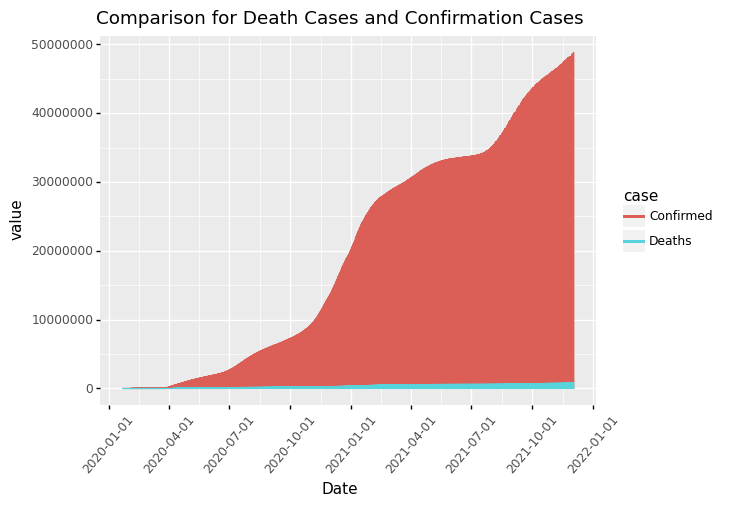

<ggplot: (142414297637)>

In [11]:
(p9.ggplot(melt_countries_agg) 
+ p9.aes(x='Date',y='value',colour = 'case') 
+ p9.geom_line() 
+ p9.labs(title = 'Comparison for Death Cases and Confirmation Cases')
+ p9.theme(axis_text_x = p9.element_text(angle=50))
)

**Observation:** 

From the plot, we can see there is a tiny positive relationship between the death cases and confirmed cases. However, Overall, however, confirmed cases far outnumber deaths. Our conclusion is that COVID-19 is highly contagious, but it does not lead to a high mortality, which is lucky.

### 2.3. Worldwide Increasing Rate Analysis
****
In this sub-section, we would like to know more about how the worldwide increasing rate change overtime. We will use `df[8]`, which is also known as worldwide-aggregate. 

Here are the specifications of its columns:
* Confirmed: The number of confirmed case.
* Date: The date of the record.
* Deaths: The number of death case.
* Increase rate: The increase rate of confirmed cases (compared to the day before).
* Recovered: The number of recovered case.


In [12]:
display(df[8].info())
df[8]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 681 entries, 0 to 680
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Confirmed      681 non-null    int64  
 1   Date           681 non-null    object 
 2   Deaths         681 non-null    int64  
 3   Increase rate  680 non-null    float64
 4   Recovered      681 non-null    int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 26.7+ KB


None

,Confirmed,Date,Deaths,Increase rate,Recovered
0,557,2020-01-22,17,NaN,30
1,655,2020-01-23,18,17.594255,32
2,941,2020-01-24,26,43.664122,39
3,1434,2020-01-25,42,52.391073,42
4,2118,2020-01-26,56,47.698745,56
...,...,...,...,...,...
676,261516487,2021-11-28,5199921,0.155401,0
677,262182281,2021-11-29,5207691,0.254590,0
678,262807532,2021-11-30,5215558,0.238480,0
679,263509565,2021-12-01,5224655,0.267128,0


In [13]:
worldwide = df[8]
worldwide['Confirmed'] = pd.to_numeric(worldwide['Confirmed'],errors='coerce')
worldwide['Increase rate'] = pd.to_numeric(worldwide['Increase rate'],errors='coerce')
worldwide['Date'] = worldwide['Date'].astype(str)
worldwide['Date'] = pd.to_datetime(worldwide['Date'])

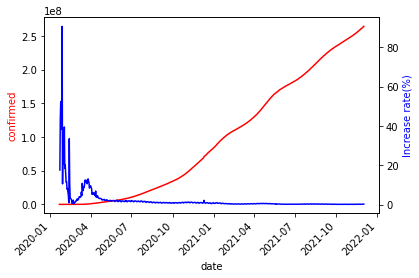

In [14]:
x = worldwide['Date']
y1 = worldwide['Confirmed']
y2 = worldwide['Increase rate']

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, y1, 'r-')
ax2.plot(x, y2, 'b-')

ax1.set_xlabel('date')
ax1.set_ylabel('confirmed', color='r')
ax2.set_ylabel('Increase rate(%)', color='b')
fig.autofmt_xdate(rotation=45)
plt.show()

**Observation**

In order to explore the increasing rate of COVID through time, we will process the data by drawing a plot with date as the x-axis, confirmed case amount as the first y-axis, and case increasing rate as the secondary y-axis. 

As can be seen from the graph, in early 2020, the growth rate of confirmed cases dropped abruptly. And the trend of increasing rate is overall decreasing. Even though the rate was raised again around April, it has fallen again since then. Until now, we had a stable and low growth rate. 

Although the growth rate of confirmed cases is extremely low, the number of confirmed cases is still increasing like crazy. We speculate that this is due to a sudden increase of the confirmed case base, which indirectly led to the decline in the growth rate. Hence we must not treat it lightly.



### 2.4. Confirmed Cases Among States Of The US
****
In the previous sub-sections, we looked into the worldwide data. In this sub-section, we will narrow our view and look specifically at the statistics of COVID-19 cases in the US, We will use the data named us_confirmed(`df[5]`) and us_deaths(`df[6]`). Since we want to analyze death cases and confirmed cases together, we will join these two dataset together.

In [4]:
us_confirmed = df[5].drop('Country/Region', 1).rename(columns={"Case": "Confirmed"})
us_deaths = df[6].drop('Country/Region', 1).rename(columns={"Case": "Deaths"})

In [5]:
us_simplified = us_confirmed.merge(us_deaths,how='left', left_on=['Date','Province/State','Admin2'], 
                   right_on = ['Date','Province/State','Admin2'])
us_simplified

,Admin2,Confirmed,Date,Province/State,Deaths
0,Autauga,0,2020-01-22,Alabama,0
1,Autauga,0,2020-01-23,Alabama,0
2,Autauga,0,2020-01-24,Alabama,0
3,Autauga,0,2020-01-25,Alabama,0
4,Autauga,0,2020-01-26,Alabama,0
...,...,...,...,...,...
2279239,Weston,1193,2021-11-29,Wyoming,13
2279240,Weston,1193,2021-11-30,Wyoming,14
2279241,Weston,1193,2021-12-01,Wyoming,14
2279242,Weston,1195,2021-12-02,Wyoming,14


Via `merge` function, we form our data. 
First of all, we will check the summary of US cases. 

In [17]:
us_simplified.describe()

,Confirmed,Deaths
count,2.269218e+06,2.269218e+06
mean,5.907236e+03,1.085574e+02
std,2.758112e+04,5.353860e+02
min,0.000000e+00,0.000000e+00
25%,5.000000e+01,0.000000e+00
50%,7.990000e+02,1.400000e+01
75%,3.305000e+03,6.100000e+01
max,1.527132e+06,2.716600e+04


Above is the summary for all states in the US. 

Then we want to show the top 10 states with the highest death and confirmed cases. Since our data list deaths and confirmations separately by date, we need to sum them together to get the total number through `groupby` in pandas. We will order the number of cases by decreasing order.

In [6]:
death_us = us_simplified.groupby(['Province/State']).agg({'Deaths':'sum'})
death_us = death_us.reset_index() #G4--index
us_top10 = death_us.sort_values([ 'Deaths'], ascending=False).groupby('Province/State').head(10)[0:10]
us_top10

,Province/State,Deaths
36,New York,25881652
5,California,23249556
49,Texas,20908115
11,Florida,16222038
34,New Jersey,12546559
43,Pennsylvania,11020433
17,Illinois,10626403
12,Georgia,8587446
26,Michigan,8542302
40,Ohio,8165576


We can see that New York has the greatest number of death cases in the US which is more than 25 million followed by the death amount of California and Texas. 

Let's do the same for confirmed cases.

In [7]:
confirmed_us = us_simplified.groupby(['Province/State']).agg({'Confirmed':'sum'})
confirmed_us = confirmed_us.reset_index() #G4--index
us_top10c = confirmed_us.sort_values([ 'Confirmed'], ascending=False).groupby('Province/State').head(10)[0:10]
us_top10c

,Province/State,Confirmed
5,California,1540813004
49,Texas,1233540205
11,Florida,1011523116
36,New York,818777906
17,Illinois,553397761
12,Georgia,474339757
43,Pennsylvania,454386229
40,Ohio,435740670
37,North Carolina,407294407
34,New Jersey,392343203


From the data frame, California has the greatest confirmed cases  in the US which is more than 1.5 billion. 

In order to show the data more clearly, we do data visualization.

In [62]:
high = us_simplified[(us_simplified['Confirmed'] >= 3.241000e+03) 
                     & (us_simplified['Deaths'] >= 6.000000e+01)]
high

,Admin2,Confirmed,Date,Province/State,Deaths
365,Autauga,5270,2021-01-21,Alabama,61
366,Autauga,5327,2021-01-22,Alabama,61
367,Autauga,5358,2021-01-23,Alabama,62
368,Autauga,5376,2021-01-24,Alabama,62
369,Autauga,5407,2021-01-25,Alabama,62
...,...,...,...,...,...
2275829,Sweetwater,8106,2021-11-29,Wyoming,97
2275830,Sweetwater,8117,2021-11-30,Wyoming,101
2275831,Sweetwater,8123,2021-12-01,Wyoming,101
2275832,Sweetwater,8130,2021-12-02,Wyoming,101


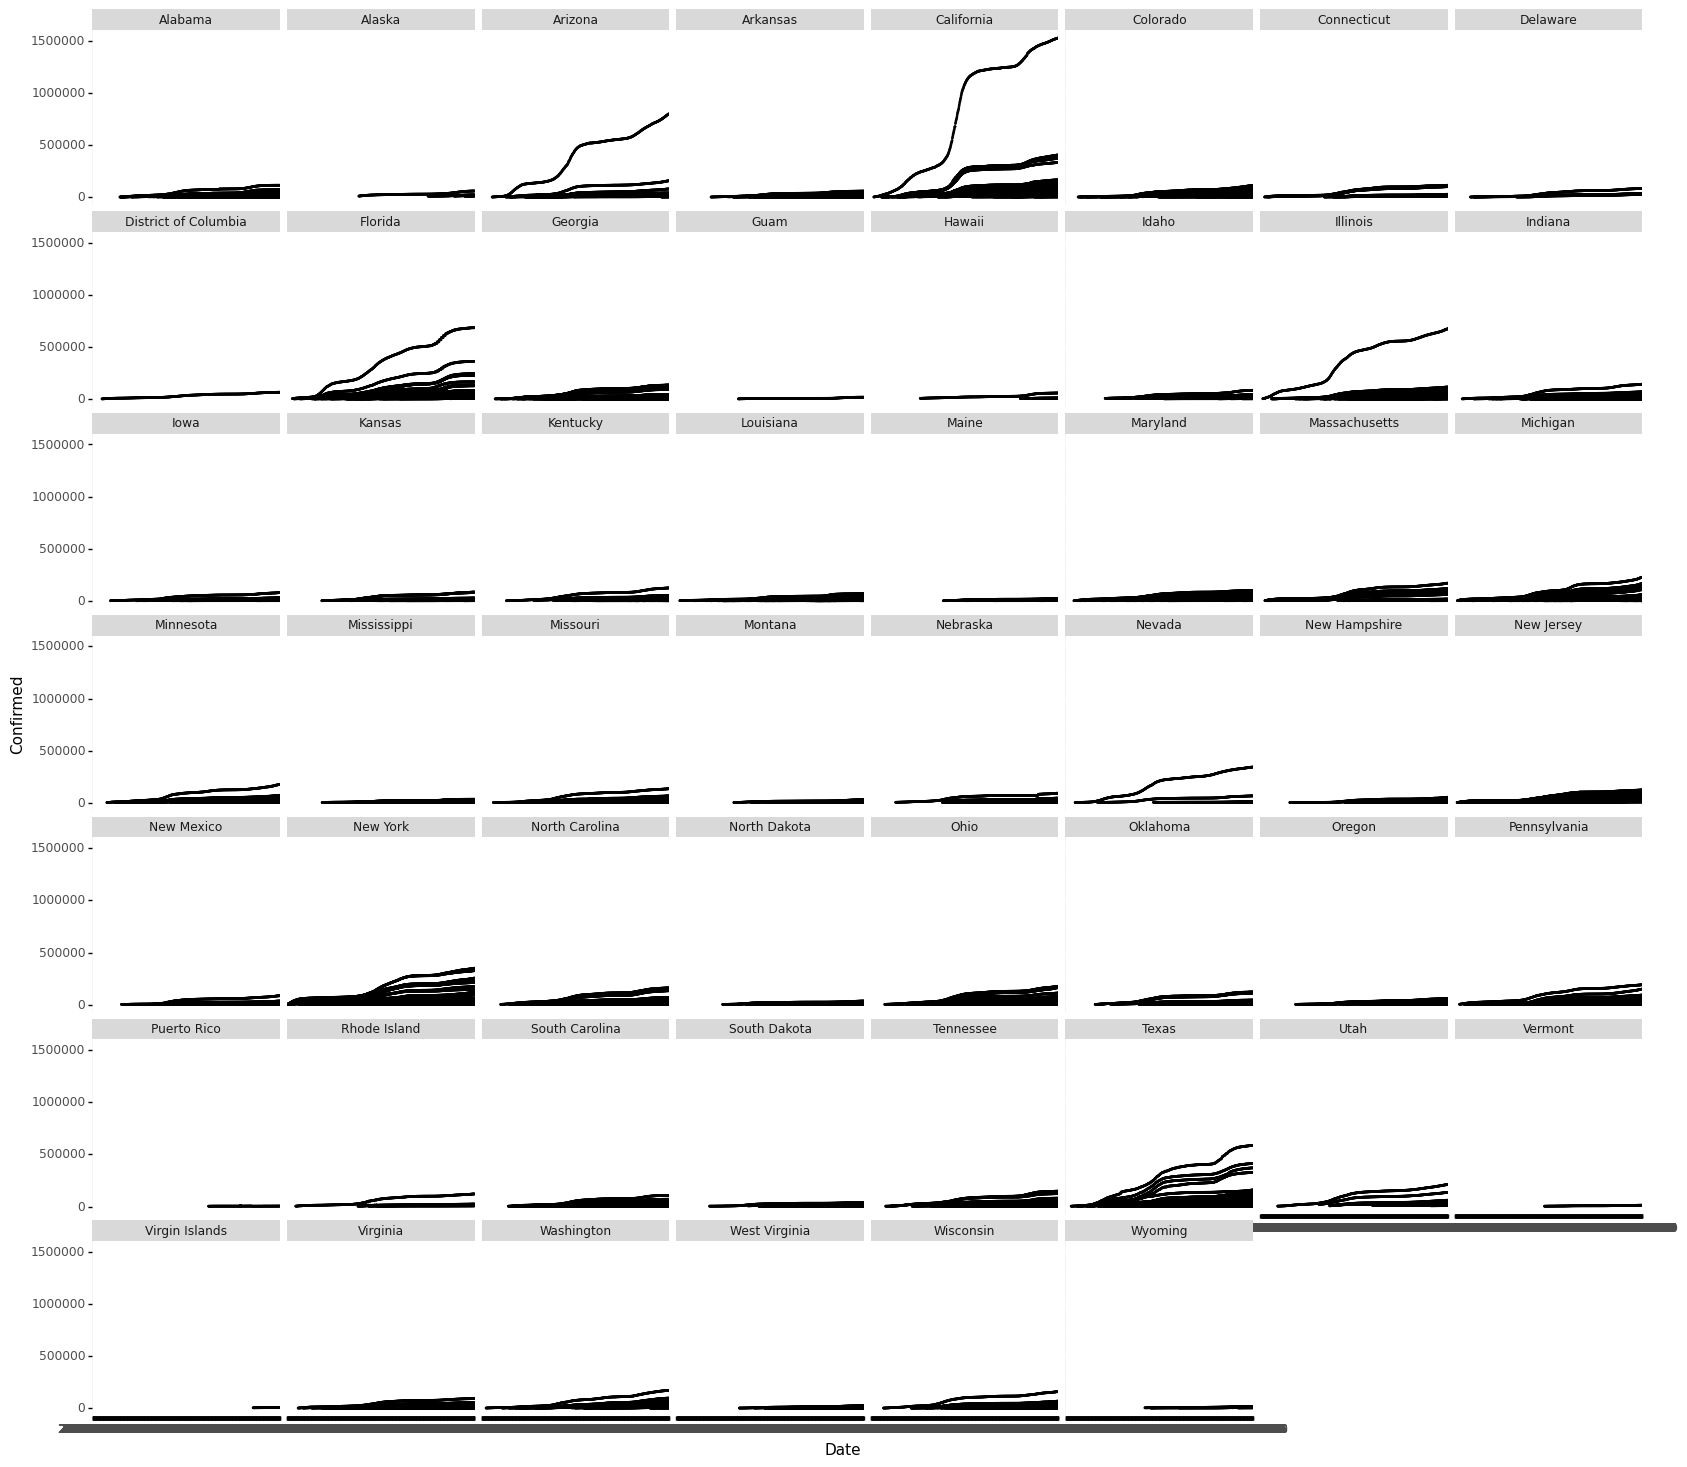

<ggplot: (145026408256)>

In [21]:
gg = ggplot(high)
gg += p9.facet_wrap('Province/State')  
gg += p9.aes(x='Date', y='Confirmed')
gg += geom_point(size = 0.1)
gg += theme(figure_size=(20, 18))
gg

Again, we can see that California has the largest confirmed cases. 

Then, we will join the two table to get countries that are in both of the top 10 lists. Those countries will be the ones with both top serious deaths and confirmations.

In [9]:
us_top10.merge(us_top10c,on='Province/State') #join data

,Province/State,Deaths,Confirmed
0,New York,25881652,818777906
1,California,23249556,1540813004
2,Texas,20908115,1233540205
3,Florida,16222038,1011523116
4,New Jersey,12546559,392343203
5,Pennsylvania,11020433,454386229
6,Illinois,10626403,553397761
7,Georgia,8587446,474339757
8,Ohio,8165576,435740670


**Observation**

From the statistics above, New York, California, Texas, Florida, New Jersey, Pennsylvania, Illinois, Georgia and Ohio are the states with the highest number of both deaths and confirmed cases. Our conclusion is that these are the states with the worst COVID-19 problems and they need to take measures immediately to control the spread of Covid-19.

### 2.5. Confirmed & Vaccinated Cases Among Counties Of California
****
In this sub-section, furthermore, we would like to get into more detail of California, which has the greatest confirmed case number. we will use the new data frame 'Statewide COVID-19 Vaccines Administered By County'. Let's read the data in chunks and get its basic information. 

The new data has the following columns:
* County: The name of the county
* administered_date: The date of admission
* total_doses: Total number of doses available
* cumulative_total_doses: The total number of doses since the beginning
* pfizer_doses: The number of doses from pfizer
* cumulative_pfizer_doses: The total number of doses from pfizer since the beginning
* moderna_doses: The number of doses from moderna
* cumulative_moderna_doses: The total number of doses from moderna since the beginning
* jj_doses: The number of doses from Johnson & Johnson vaccine
* cumulative_jj_doses: The total number of doses from Johnson & Johnson vaccine since the beginning
* partially_vaccinated: Number of vaccination that does not complete the second shot
* total_partially_vaccinated: The total number of vaccination that does not complete the second shot since the beginning
* fully_vaccinated: Number of vaccination that complete the second shot
* total_fully_vaccinated: The total number of vaccination that complete the second shot since the beginning
* at_least_one_dose: Number of people who had at least one dose of vaccin
* cumulative_at_least_one_dose: Total number of people who had at least one dose of vaccin since the beginning
* california_flag: Dose is flagged in california
* booster_recip_count: Number of booster shot
* cumulative_booster_recip_count: Total number of booster shot since the beginning

To easily manage the data, we store the dataframe into an sqlite database.

In [10]:
vac = pd.read_csv('https://data.chhs.ca.gov/dataset/e283ee5a-cf18-4f20-a92c-ee94a2866ccd/resource/130d7ba2-b6eb-438d-a412-741bde207e1c/download/covid19vaccinesbycounty.csv',
                  chunksize=10000)

vac_chunk = next(vac)
vac_chunk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   county                          10000 non-null  object
 1   administered_date               10000 non-null  object
 2   total_doses                     10000 non-null  int64 
 3   cumulative_total_doses          10000 non-null  int64 
 4   pfizer_doses                    10000 non-null  int64 
 5   cumulative_pfizer_doses         10000 non-null  int64 
 6   moderna_doses                   10000 non-null  int64 
 7   cumulative_moderna_doses        10000 non-null  int64 
 8   jj_doses                        10000 non-null  int64 
 9   cumulative_jj_doses             10000 non-null  int64 
 10  partially_vaccinated            10000 non-null  int64 
 11  total_partially_vaccinated      10000 non-null  int64 
 12  fully_vaccinated                10000 non-null 

Then, we will append the data to sql sqlite through chunks. 

In [11]:
sqlite_file = 'vac_sql.sqlite'
vac_sql = sqla.create_engine('sqlite:///' + sqlite_file)
vac_chunk.to_sql('vac',vac_sql,if_exists='replace')
for vac_chunk in vac:
    vac_chunk.to_sql('vac',vac_sql,if_exists='append')
pd.read_sql_query("select count(*) from vac",vac_sql)

,count(*)
0,30628


After appending all columns into our sql sqlite, we want to check amount of cumulative fully vaccinated population in CA counties through time. We will use sql commend to select the date column and cumulative fully vaccination column in CA counties and group by date.

In [12]:
sql_query = """
select administered_date,cumulative_fully_vaccinated from vac 
where county = 'All CA Counties' 
group by administered_date
"""
CA_vac_time = pd.read_sql_query(sql_query,vac_sql)
CA_vac_time

,administered_date,cumulative_fully_vaccinated
0,2020-07-27,0
1,2020-07-28,1
2,2020-07-29,1
3,2020-07-30,2
4,2020-07-31,2
...,...,...
489,2021-11-29,25136009
490,2021-11-30,25187243
491,2021-12-01,25240621
492,2021-12-02,25291808


Let's visualize the time series to see vaccination trend. 

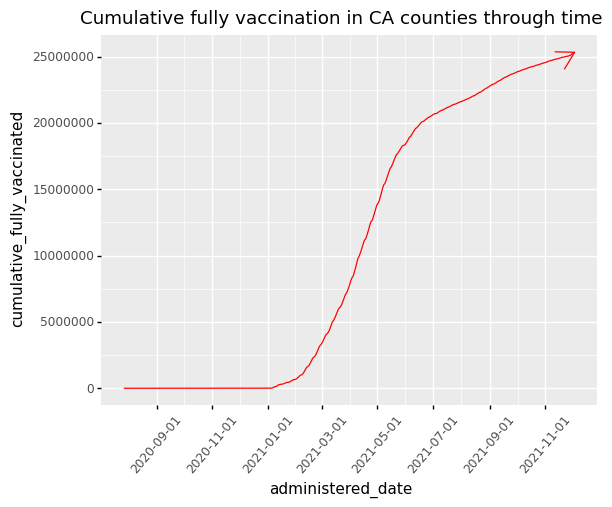

<ggplot: (8775053962141)>

In [13]:
CA_vac_time['administered_date'] = pd.to_datetime(CA_vac_time['administered_date'].astype(str))
(p9.ggplot(CA_vac_time) 
+ p9.aes(x='administered_date',y='cumulative_fully_vaccinated') 
+ p9.geom_line(arrow = arrow(),color='red') 
+ p9.labs(title = 'Cumulative fully vaccination in CA counties through time')
+ p9.theme(axis_text_x = p9.element_text(angle=50))
)

**Observation**

The plot above conveys that the US government started to popularize the vaccine in January and achieved great success in vaccination. From February 2021 to July 2021, the total vaccine coverage rate increased the most among all periods, forming an an "S" shaped smooth in smooth out trend.

In [14]:
# https://data.chhs.ca.gov/api/3/action/datastore_create
vac_url  = 'https://data.chhs.ca.gov/dataset/e283ee5a-cf18-4f20-a92c-ee94a2866ccd/resource/130d7ba2-b6eb-438d-a412-741bde207e1c/download/covid19vaccinesbycounty.csv'
vac_data = pd.read_csv(vac_url)
California_simplified = us_simplified[us_simplified['Province/State'] == 'California']
#c = dff2.groupby(['FIPS',pd.Grouper(key = 'Date',freq = '7d')])['incidence_prop'].sum()
California_simplified

,Admin2,Confirmed,Date,Province/State,Deaths
134354,Alameda,0,2020-01-22,California,0
134355,Alameda,0,2020-01-23,California,0
134356,Alameda,0,2020-01-24,California,0
134357,Alameda,0,2020-01-25,California,0
134358,Alameda,0,2020-01-26,California,0
...,...,...,...,...,...
175269,Yuba,10760,2021-11-29,California,89
175270,Yuba,10763,2021-11-30,California,89
175271,Yuba,10763,2021-12-01,California,89
175272,Yuba,10781,2021-12-02,California,89


In [51]:
#combine confried/Deaths to the vaccine data
vaccine = California_simplified.merge(vac_data,how='inner', left_on=['Date','Admin2'], 
                   right_on = ['administered_date','county'])
us_confirmed = df[5].drop('Country/Region', 1)
vaccine = vaccine.drop(['administered_date','Admin2','Province/State','california_flag'],1)
vaccine 

,Confirmed,Date,Deaths,county,total_doses,cumulative_total_doses,pfizer_doses,cumulative_pfizer_doses,moderna_doses,cumulative_moderna_doses,jj_doses,cumulative_jj_doses,partially_vaccinated,total_partially_vaccinated,fully_vaccinated,cumulative_fully_vaccinated,at_least_one_dose,cumulative_at_least_one_dose,booster_recip_count,cumulative_booster_recip_count
0,10689,2020-07-27,176,Alameda,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,10922,2020-07-28,180,Alameda,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,11225,2020-07-29,180,Alameda,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,11356,2020-07-30,185,Alameda,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,11537,2020-07-31,187,Alameda,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28647,10760,2021-11-29,89,Yuba,233,74032,51,30362,158,38960,8,4286,33,3915,31,34308,37,38223,169,5349
28648,10763,2021-11-30,89,Yuba,317,74349,62,30424,206,39166,9,4295,54,3919,56,34364,60,38283,204,5553
28649,10763,2021-12-01,89,Yuba,291,74640,90,30514,166,39332,10,4305,56,3926,53,34417,60,38343,181,5734
28650,10781,2021-12-02,89,Yuba,334,74974,81,30595,193,39525,16,4321,60,3937,53,34470,64,38407,221,5955


In [52]:
# group data with county and timefrequency(month)
vaccine['Date'] = pd.to_datetime(vaccine['Date'].astype(str)).values
month = vaccine.groupby(['county',pd.Grouper(key = 'Date',freq='M')]).sum()
month['fully_vaccinated']=month['fully_vaccinated'].transform(lambda x: x.cumsum())
month

Confirmed  Deaths  total_doses  cumulative_total_doses  \
county  Date                                                                 
Alameda 2020-07-31      55729     908            0                       0   
        2020-08-31     470022    6770           30                     353   
        2020-09-30     585066    9385           51                    1744   
        2020-10-31     703279   12207            8                    2693   
        2020-11-30     800147   13066           12                    2818   
...                       ...     ...          ...                     ...   
Yuba    2021-08-31     233483    1610         5796                 1711919   
        2021-09-30     273721    1798         5539                 1835161   
        2021-10-31     310059    2377         4391                 2043652   
        2021-11-30     318068    2573         6200                 2143680   
        2021-12-31      32342     269          821                  224784   

                    pfizer_doses  cumulative_pfizer_doses  moderna_doses  \
county  Date                                                               
Alameda 2020-07-31             0                        0              0   
        2020-08-31            28                      329              2   
        2020-09-30            49                     1647              2   
        2020-10-31             7                     2557              1   
        2020-11-30             6                     2596              2   
...                          ...                      ...            ...   
Yuba    2021-08-31          3380                   653178           2098   
        2021-09-30          3265                   736637           2000   
        2021-10-31          2433                   851135           1795   
        2021-11-30          1890                   887315           3609   
        2021-12-31           213                    91746            463   

                    cumulative_moderna_doses  jj_doses  cumulative_jj_doses  \
county  Date                                                                  
Alameda 2020-07-31                         0         0                    0   
        2020-08-31                        24         0                    0   
        2020-09-30                        97         0                    0   
        2020-10-31                       136         0                    0   
        2020-11-30                       172         4                   50   
...                                      ...       ...                  ...   
Yuba    2021-08-31                    950971       317               107315   
        2021-09-30                    985692       271               112343   
        2021-10-31                   1069097       162               122846   
        2021-11-30                   1124786       256               125220   
        2021-12-31                    118486        45                12966   

                    partially_vaccinated  total_partially_vaccinated  \
county  Date                                                           
Alameda 2020-07-31                     0                           0   
        2020-08-31                    28                         349   
        2020-09-30                    14                         481   
        2020-10-31                     4                         134   
        2020-11-30                     7                         188   
...                                  ...                         ...   
Yuba    2021-08-31                  3263                      140162   
        2021-09-30                  2056                      137856   
        2021-10-31                  1174                      118235   
        2021-11-30                  1311                      113048   
        2021-12-31                   140                       11786   

                    fully_vaccinated  cumulative_fu

In [54]:
vac_conn = sqla.create_engine('sqlite:///vac_sql.sqlite')
# vac_vaccine.to_sql('vaccine',vac_conn,if_exists='append')

for i in range(len(month['Confirmed'])):
    if i==0:
        month.to_sql('vaccine',vac_conn,if_exists='replace')
    elif i>0:
        month.to_sql('vaccine',vac_conn,if_exists='append')


In [60]:
# observe the fully_vaccinated rate have correlation to confirmed & deaths rage
fully_vac = pd.read_sql_query("select county,confirmed,deaths,fully_vaccinated,Date from vaccine group by county,Date", vac_conn)

fully_vac

,county,Confirmed,Deaths,fully_vaccinated,Date
0,Alameda,55729,908,0,2020-07-31 00:00:00.000000
1,Alameda,470022,6770,2,2020-08-31 00:00:00.000000
2,Alameda,585066,9385,39,2020-09-30 00:00:00.000000
3,Alameda,703279,12207,43,2020-10-31 00:00:00.000000
4,Alameda,800147,13066,47,2020-11-30 00:00:00.000000
...,...,...,...,...,...
1039,Yuba,233483,1610,25323300,2021-08-31 00:00:00.000000
1040,Yuba,273721,1798,25326409,2021-09-30 00:00:00.000000
1041,Yuba,310059,2377,25328203,2021-10-31 00:00:00.000000
1042,Yuba,318068,2573,25329384,2021-11-30 00:00:00.000000


In [41]:
county = fully_vac['county'].unique()

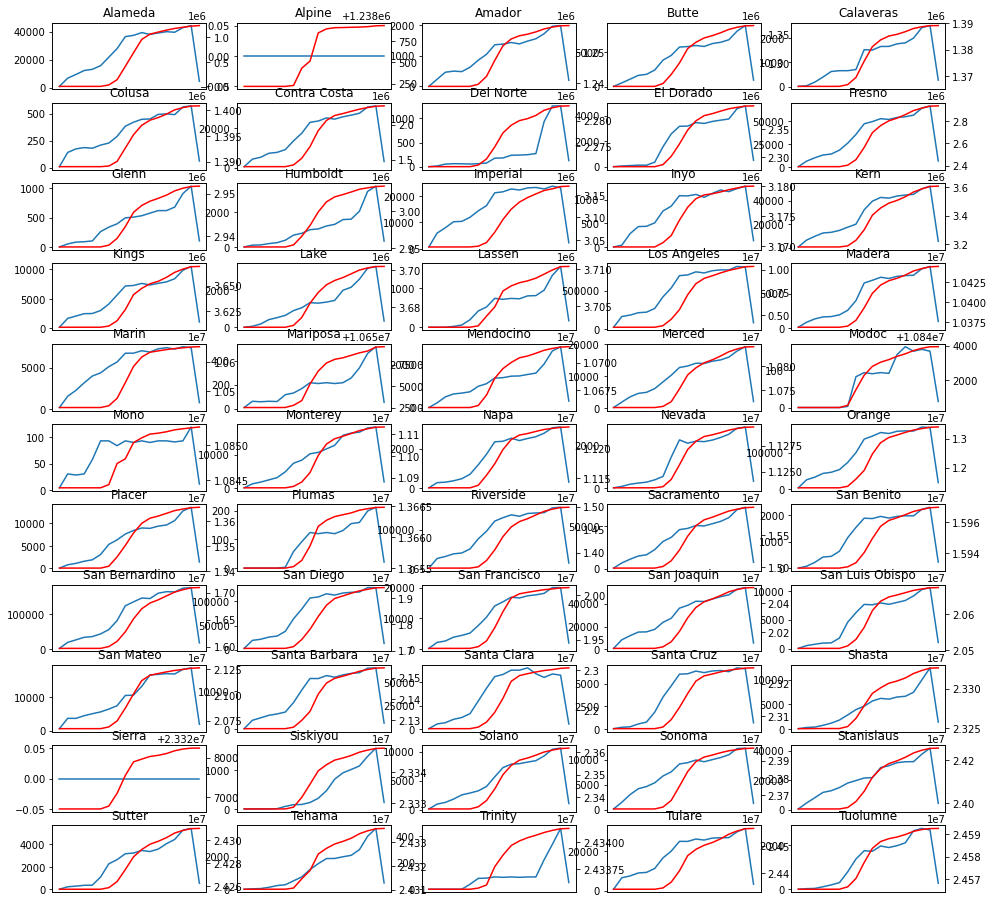

In [42]:
# gg = ggplot(fully_vac)
# gg += p9.facet_wrap('county')  
# gg += geom_point(p9.aes(x='Date', y='fully_vaccinated'),size = 0.1)
# gg += geom_point(p9.aes(x='Date', y='Confirmed'),size = 0.1)
# gg


fig, ax= plt.subplots(11,5, figsize=(16,16))


# for i in range(1, 7):
#     plt.subplot(2, 3, i)
#     plt.title('Histogram of {}'.format(str(i)))
#     plt.hist(x[:,i-1], bins=60)
# ax[0].plot(fully_vac[fully_vac['county']=='Alameda']['Date'],
#              fully_vac[fully_vac['county']=='Alameda']['Confirmed'])
for i in range(11):
    for j in range(5):
        ax[i,j].plot(fully_vac[fully_vac['county']==county[i*5+j]]['Date'],
                     fully_vac[fully_vac['county']==county[i*5+j]]['Deaths'])
#         ax[i,j].secondary_yaxis(fully_vac[fully_vac['county']==county[i*5+j]]['fully_vaccinated'])

        ax[i,j].axes.xaxis.set_visible(False)
        ax[i,j].set_title(county[i*5+j])
        
        axx = ax[i,j].twinx()
        axx.plot(fully_vac[fully_vac['county']==county[i*5+j]]['Date'],
                        fully_vac[fully_vac['county']==county[i*5+j]]['fully_vaccinated'],
                color='red')
#         lns2 = axx.axes.xaxis.set_visible(False)
#         fig.tight_layout()
#         plt.show()
   

**Observation**

In order to present the relationship between the death case amount and the number of people full vaccinated, we process the data by drawing a plot with date as the x-axis, death case amount as the first y-axis, and the number of people full vaccinated as the secondary y-axis.

As can be seen from the picture, almost all counties are making efforts to get people vaccinated. While the number of deaths per month continues to increase over time, this is inevitable as the population base of confirmed cases increases over time.

Surprisingly, starting November 30, 2021, every county in the United States experienced a sudden drop in death amount caused by Covid-19. The underlying factors are still unclear, but we believe that the U.S. government has worked very hard to put the serious situation posed by COVID-19 in control.

## 3. Exploratory Analysis
****
Unlike previous sectins, we look beyond simply plotting out the time series in this section. We want to discover the relationships between the variables. In other words, we want to know if one variable is correlated/dependent on other variables.


### 3.1. Boost Shot's Impact On COVID-19 Death Rate In California
****
From the previous sections, we observe significant drops in death and confirmed cases during a certain periods. We suspect this has something to do with the vaccination as well as booster shots. We will find it out in this section.

In [37]:
boost_df = pd.read_sql_query("SELECT county,deaths,confirmed,booster_recip_count,Date FROM vaccine GROUP BY county,Date", vac_conn)
boost_df["Death Rate"] = boost_df["Deaths"]/boost_df["Confirmed"]
boost_df

,county,Deaths,Confirmed,booster_recip_count,Date,Death Rate
0,Alameda,908,55729,0,2020-07-31 00:00:00.000000,0.016293
1,Alameda,6770,470022,0,2020-08-31 00:00:00.000000,0.014404
2,Alameda,9385,585066,0,2020-09-30 00:00:00.000000,0.016041
3,Alameda,12207,703279,0,2020-10-31 00:00:00.000000,0.017357
4,Alameda,13066,800147,0,2020-11-30 00:00:00.000000,0.016329
...,...,...,...,...,...,...
981,Yuba,1592,201429,0,2021-07-31 00:00:00.000000,0.007904
982,Yuba,1610,233483,128,2021-08-31 00:00:00.000000,0.006896
983,Yuba,1798,273721,349,2021-09-30 00:00:00.000000,0.006569
984,Yuba,2377,310059,1408,2021-10-31 00:00:00.000000,0.007666


<AxesSubplot:title={'center':'California Mean Death Rate vs. Boost Shots'}, xlabel='booster_recip_count', ylabel='Death Rate'>

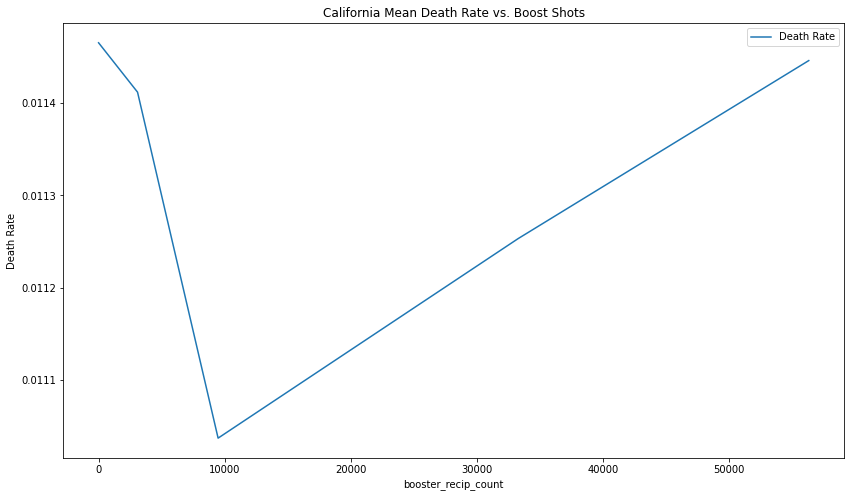

In [38]:
# First let's take a look on the impact of booster shots on the average death rate among all of the Californian counties.
boost_mean = boost_df.groupby("Date").mean().groupby("booster_recip_count").mean().reset_index()
boost_mean.plot("booster_recip_count", 
                "Death Rate", 
                figsize=(14, 8), 
                title="California Mean Death Rate vs. Boost Shots",
                ylabel="Death Rate"
               )

**Observation:** 

The figure conveys that the death rate decreased drastically when the booster shot gradually increases from 0 to around 9000, however, the death rate increases ain a stable speed as the boost shot increase from 9000 on. 

We have several possible explainations to this abnomalty:
* The new mutant: The virus evolve, too. While people are getting the booster shots, the virus became more lethal.
* Vaccine Storage: The amount of people overwhelms the vaccin storage so even people wants to get booster shot, there are not enough vaccine for them.
* Only Delayed: The booster shot only delayed the symptoms, it does not mitigate the mortality rate at all.

### 3.2. Vaccine Amount's Impact On COVID-19 Death Rate In California
The boost shot's performance on the COVID-19 death rate in California is not as expected, what about vaccination amount? Will it affect how the Covid-19 death rate positively?

In [39]:
vaccine_df = pd.read_sql_query("SELECT county,deaths,confirmed,total_doses,pfizer_doses,moderna_doses,jj_doses,Date FROM vaccine GROUP BY county,Date", vac_conn)
vaccine_df["Death Rate"] = vaccine_df["Deaths"]/vaccine_df["Confirmed"]
vaccine_df

,county,Deaths,Confirmed,total_doses,pfizer_doses,moderna_doses,jj_doses,Date,Death Rate
0,Alameda,908,55729,0,0,0,0,2020-07-31 00:00:00.000000,0.016293
1,Alameda,6770,470022,30,28,2,0,2020-08-31 00:00:00.000000,0.014404
2,Alameda,9385,585066,51,49,2,0,2020-09-30 00:00:00.000000,0.016041
3,Alameda,12207,703279,8,7,1,0,2020-10-31 00:00:00.000000,0.017357
4,Alameda,13066,800147,12,6,2,4,2020-11-30 00:00:00.000000,0.016329
...,...,...,...,...,...,...,...,...,...
981,Yuba,1592,201429,3879,2237,1335,307,2021-07-31 00:00:00.000000,0.007904
982,Yuba,1610,233483,5795,3380,2097,317,2021-08-31 00:00:00.000000,0.006896
983,Yuba,1798,273721,5539,3264,2001,271,2021-09-30 00:00:00.000000,0.006569
984,Yuba,2377,310059,4391,2433,1795,162,2021-10-31 00:00:00.000000,0.007666


In [40]:
melt_vaccine = pd.melt(
    vaccine_df, 
    id_vars=["Death Rate"], 
    value_vars=['total_doses', 'pfizer_doses', 'moderna_doses', 'jj_doses'],
    var_name="dose_type",
    value_name="dose_count"
)
melt_vaccine

,Death Rate,dose_type,dose_count
0,0.016293,total_doses,0
1,0.014404,total_doses,30
2,0.016041,total_doses,51
3,0.017357,total_doses,8
4,0.016329,total_doses,12
...,...,...,...
3939,0.007904,jj_doses,307
3940,0.006896,jj_doses,317
3941,0.006569,jj_doses,271
3942,0.007666,jj_doses,162


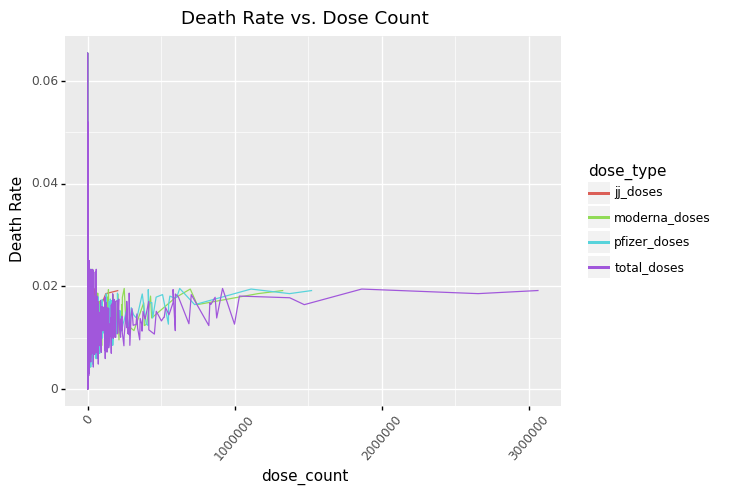

<ggplot: (142332477579)>

In [41]:
(p9.ggplot(melt_vaccine)
+ p9.aes(x='dose_count',y='Death Rate',colour='dose_type') 
+ p9.geom_line() 
+ p9.labs(title = 'Death Rate vs. Dose Count')
+ p9.theme(axis_text_x = p9.element_text(angle=50))
)

**Observation:**

As the dose amount increases, their line plot changes from tortuous shape to smoothed. This suggests that vaccination helps keep mortality rates below 2%. But they appear to have weak linear relationship with the death rate.

Note: That the amount of vaccine offerd by Pfizer and Moderna is much larger than the one offed by Johnson & Johnson vaccine is because that Johnson & Johnson vaccine is the lastest vaccine put into use, which means that the data of which should less than the amount of vaccine offerd by Pfizer and Moderna.

### 3.3. Best Vaccine In California
In the previous section, we see that the number of vaccination does contribute to a lower death rate and there appear a weak linear relationship with the death rate and vaccination amount. But what is the best vaccine that reduce the most death rate? In this sub-section, we will take advantage of the linear regression model to find it out.

In [42]:
X = vaccine_df[['pfizer_doses', 'moderna_doses', 'jj_doses']]
y = vaccine_df["Death Rate"]
X = sm.add_constant(X)
model = sm.OLS(y, X, missing="drop")
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Death Rate   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     8.338
Date:                Sun, 05 Dec 2021   Prob (F-statistic):           1.77e-05
Time:                        01:13:22   Log-Likelihood:                 3511.2
No. Observations:                 985   AIC:                            -7014.
Df Residuals:                     981   BIC:                            -6995.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0111      0.000     47.857      0.000       0.011       0.012
pfizer_doses    2.21e-08   6.76e-09      3.270      0.001    8.84e-09    3.54e-08
moderna_doses -1.591e-08   8.51e-09     -1.870      0.062   -3.26e-08    7.89e-10
jj_doses      -1.668e-08   4.77e-08     -0.350      0.727    -1.1e-07    7.69e-08
==============================================================================
Omnibus:                      542.537   Durbin-Watson:                   0.334
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7019.324
Skew:                           2.238   Prob(JB):                         0.00
Kurtosis:                      15.288   Cond. No.                     1.46e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.46e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Observation:**

In order to check the linear regression model, here we check the p-values first. In general, if the pvalue is < 0.05, it means the null hypothesis of the correlated variable that does not have any impact on the target is rejected. 

In the form, `pfizer_doses` has a p-value of 0.01, `moderna_doses` has 0.062, `jj_doses` has 0.727. We can see only `pfizer_doses` has a p-value that smaller than 0.05. However, since pfizer is the earliest that has been put into use, we may assume that the reason why the other two doses fail to reject the null hypothesis is due to lack of data. 

Let us assume that they all reject the null hypothesis for now. we obtain that: every 1 dose of `pfizer` vaccine may increase the death rate by 2.21e-08, 1 dose of `moderna` vaccine can decrease the death rate by 1.591e-08, and one dose of `jj` vaccine can reduce the death rate by 1.668e-08. Obviously, Johnson & Johnson vaccine has a betther performance. 

We can conclude that the newer the vaccine, the more efficient they become to reduce the death rate, which make sense in real life.

## 4. Conclusion

In this project, we conducted in depth analysis on the COVID-19 data and observed many interesting patterns.We collected our data for COVID-19 data from DataHub.com. 

Through analysis, we found out that there is an overall upward trend in every country, with the United States leading the way and China performs well on controlling the virus. Even though COVID-19 has a high infection rate, but the mortality seems much lower than expected. Since US's situation is worse than others, we further analyze the data for the county in US. Within US, New York, California, Texas, Florida, New Jersey, Pennsylvania, Illinois, Georgia and Ohio are facing difficulty about how to handle Covid-19. California has the highest confirmed case amount and New York has the highest death case amount. 

As a primary protection from Covid-19, vaccines have been our main focus in relation to the virus. We develope our research by adding the factor of vaccine. From the research, we observe that countries managed to increase the rate of people fully vaccined. Although the effect of vaccine is not quite significant, the vaccine has an ability to slow down the increasing rate of confirmed cases and death cases. And it does help the world stabilize the mortality less than 2%. As the lastest vacine, Johnson & Johnson vaccine seems more efficient campared to other two vaccines, Pfizer and Moderna. We also conclude that the newer the vaccine, the more efficient they become to reduce the death rate.

In a nutshell, human being is facing a disaster brought by the nature. Although the virus is evolving, through the progress of human intelligence and technology, we are controlling the epidemic step by step. 